Group: MaRä: Amanda Maiwald [*#599665*], Simon Rähles [*#600785*]

---



# ADAMS Mini Challenge 2

## Introduction

Introduction: 
In the following work performance, a dataset of textual book reviews from Amazon will be used to predict its rating on a 1 - 5 star scale. Therefore, the textual data will be preprocessed in a first step, cleaning and preparing the whole data set. In a second step, the preprocessed data will be used to set up a model, predicting the star ratings based on the reviews. To do so, several language processing technics, including tokenization andlemmatization, will be used to train a word2vec model. In a last step the embeddings, as a part of the word2vec model, will feed a neural network to predict in the end the star ratings.  To evaluate the overall performance of the model, a benchmark will be introduced throughout the implementation process. 

## Import packages and setup

### Import packages

In [ ]:
import pandas as pd
import numpy as np
import keras as keras
from keras.utils import np_utils
import re

from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

import matplotlib.pyplot as plt
%matplotlib inline

### Import data

In [6]:
MC2 = pd.read_csv('MC2.csv')
MC2test = pd.read_csv('MC2test.csv')

In [7]:
MC2.head(3) # Check that everything worked out


,Unnamed: 0,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
0,1,0983797706,Igniting Your True Purpose and Passion: A Busi...,5,0,0,N,This is an inspirational and insightful book t...,This is an inspirational and insightful book t...
1,2,1423151283,The Duckling Gets a Cookie!? (Pigeon),5,0,0,N,Loved it!,My twins are 3 and they love the pigeon books!...
2,3,1445604752,Spitfire Ace of Aces: The Wartime Story of Joh...,4,2,2,N,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo..."


In [8]:
MC2test.head(3)

,Unnamed: 0,product_id,product_title,helpful_votes,total_votes,verified_purchase,review_headline,review_body
0,1,1445604752,Spitfire Ace of Aces: The Wartime Story of Joh...,2,2,N,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo..."
1,2,080244864X,Hush: Moving From Silence to Healing After Chi...,1,1,N,Best Book Ever (Next to the Bible,This book has helped me through a lot this pas...
2,3,0312536984,Eviction Notice: A Hood Rat Novel (Hood Rat No...,0,0,N,Wild and Crazy,A gripping read! K'wan is on fire with this n...


## Data Analysis

The two data sets at hand stem from Amazon reviews of books. The MC data set contains seven independent variables and one dependant variable (star_rating) and 1,099,209 observations. The test set cotains the same variables excluding the dependant variable and consists of 212,849 observations. 
The predictor variables of the training data will be saved to X and the target variables to y. As this a sentiment analysis based on textual data only the two variables review_headline and review_body will be used for predictions. Since the product_id vaiable identifies each book, the product_title variable is redundant and can be eliminated.
As the star rating ranges from 1 to 5 this is a multi class problem with 5 classes. Hence the target variable star_rating needs to be transformed into 5 dummy variables via one hot encoding.

In [9]:
MC2.index # 1,099,209 observations
MC2test.index # 212,849 observations

RangeIndex(start=0, stop=212849, step=1)

In [10]:
MC2.dtypes # product_id appears to be numeric but is not because it can also contain letters
pd.isnull(MC2).any() # review_headline and review_body contain NULL 13 and 2 values
MC2.isnull().sum()
MC2[['review_headline', 'review_body']].isnull().all() # No rows were review_headline AND review_body are NULL
#MC2test.isnull().sum() # review_headline contains 3 rows with NULL values

review_headline    False
review_body        False
dtype: bool

The two variables review_title and review_body contain a few Null values, but there are no cases where both are NUll. Therefore they should both be used to predict the sentiment.

In [11]:
MC2.loc[MC2['product_id'] == '1423151283'] # product_id identifies books

,Unnamed: 0,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
1,2,1423151283,The Duckling Gets a Cookie!? (Pigeon),5,0,0,N,Loved it!,My twins are 3 and they love the pigeon books!...
14802,14803,1423151283,The Duckling Gets a Cookie!? (Pigeon),2,5,12,N,Boring,"My family loved all of Mo's books, until now. ..."


### Global Overview

The following graph shows the distribution of the target variable star_rating. It shows that it ranges from 1-5 . By far the most ratings are a 5 star rating and there are comparably few rating of 1 or 2 stars. The mean rating is 4,2 stars.

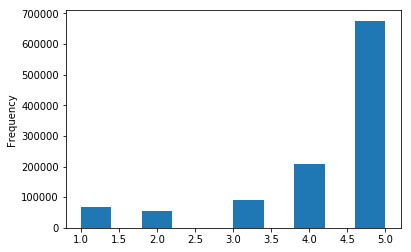

In [9]:
MC2['star_rating'].plot(kind="hist")

In [10]:
MC2['star_rating'].describe()

count    1.099209e+06
mean     4.243608e+00
std      1.184627e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: star_rating, dtype: float64

There are reviews for 540,434 different books. The most reviewed books are Breaking Dawn (The Twilight Saga, Book 4) (822 reviews), The Shack: Where Tragedy Confronts Eternity (648 reviews) and Twilight (The Twilight Saga, Book 1) (581 reviews). 364,619 (67,5%) books only have one review. Only 7% of books have 5 or more reviews. This seems to suggest that the product_id will not have a major impact on the prediction of star ratings presumably only for the few books with very high numbers o reviews.

In [11]:
review_freq = MC2['product_id'].value_counts().to_frame()

## Model

To set up the model now, we will first of all split the data into a train and test set. In a second step, we will drop redundant and non-textual variables. The outcome is a table, containing the columns product_id, review_headline and review_body.

### Save training and test data set

In [12]:
X = MC2
X = X.drop(['star_rating', 'Unnamed: 0'], axis = 1) # Drop target 'star_rating' variable and unnecessary variable 'Unnamed'
y = MC2['star_rating'] # Save target variable to y
test = MC2test.drop(['Unnamed: 0'], axis = 1) # Drop unnecessary variable 'Unnamed' from test data set

Drop redundant variables and nontextual variables.

In [13]:
X = X.drop(['product_title', 'helpful_votes', 'total_votes', 'verified_purchase'], axis = 1)
test = test.drop(['product_title', 'helpful_votes', 'total_votes', 'verified_purchase'], axis = 1)

### Data preprocessing

As the neural network only takes dummy variables, star_rating will be transformed into dummy variables. As the variables review_headline and review_body will be used for the textual analysis, merging them together and replacing NULL values with space is an essential part to simplify the further process. 

Create dummy variables for target variable star_rating.

In [15]:
encoder = LabelEncoder()
encoder.fit(MC2['star_rating'])
encoded_Y = encoder.transform(MC2['star_rating'])
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y # 5 columns, 5 levels

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

There are two textual variables review_headline and review_body that should be used for the sentiment analysis. Before that the NULL values need to be placed with space. They need to be merged. And the two separate variables dropped.

In [16]:
X['review_headline'].fillna(' ', inplace = True)
X['review_body'].fillna(' ', inplace = True)
X.isnull().any()

product_id         False
review_headline    False
review_body        False
dtype: bool

In [17]:
X['review'] = X.review_headline + ' ' + X.review_body
#X = X.drop(['review_headline', 'review_body'], axis = 1)
X.head(3)

,product_id,review_headline,review_body,review
0,0983797706,This is an inspirational and insightful book t...,This is an inspirational and insightful book t...,This is an inspirational and insightful book t...
1,1423151283,Loved it!,My twins are 3 and they love the pigeon books!...,Loved it! My twins are 3 and they love the pig...
2,1445604752,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo...",Engaging Account of the Combat Career of an RA...


Same needs to be applied to the test data.

In [29]:
test['review_headline'].fillna(' ', inplace = True)
test['review_body'].fillna(' ', inplace = True)
test.isnull().any()

product_id         False
review_headline    False
review_body        False
review              True
dtype: bool

In [73]:
test['review_headline'].fillna(' ', inplace = True)
test['review_body'].fillna(' ', inplace = True)
test.isnull().any()

product_id         False
review_headline    False
review_body        False
dtype: bool

In [31]:
test['review'] = test.review_headline + ' ' + MC2test.review_body
#test = test.drop(['review_headline', 'review_body'], axis = 1)
test.head(3)

,product_id,review_headline,review_body,review
0,1445604752,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo...",Engaging Account of the Combat Career of an RA...
1,080244864X,Best Book Ever (Next to the Bible,This book has helped me through a lot this pas...,Best Book Ever (Next to the Bible This book ha...
2,0312536984,Wild and Crazy,A gripping read! K'wan is on fire with this n...,Wild and Crazy A gripping read! K'wan is on f...


### Benchmark model

First of a simple benchmark model will be created. The score of this model will later be compard the the scre of the more complex model to evaluate its performance.
Split data into training and test set:

In [169]:
from sklearn.model_selection import train_test_split

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X['review'], y, test_size=0.25, random_state=111)

In [170]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer() # text data needs to be vectorized
vectorizer.fit(X_train_b)

X_train_b = vectorizer.transform(X_train_b)
X_test_b  = vectorizer.transform(X_test_b)

In [24]:
from sklearn.linear_model import LogisticRegression

#classifier = LogisticRegression(solver="lbfgs")
classifier = LogisticRegression(solver="saga") # saga for large data sets
classifier.fit(X_train_b, y_train_b)
score_lr = classifier.score(X_test_b, y_test_b)

print("Accuracy:", score_lr) # Accuracy with saga: 0,6836

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy: 0.6836242690218084


The accuracy of the logistic regression model amounts to 0.68. This will be the score that the following models will be compared to.

### Word tokenization

To further prepare the text as an input for the word2vec model, the text will be tokenized. In other words, the text will be segmented into words, punctuations et cetera. To avoid confusion for the further processing algorithms, non-alphabetic characters will be removed, as well as html content will be dropped in a cleaning step of the text. In addition to that, the words will be lemmatized, which means that the words will be grouped together to their lemma (for example “was” --> “be” or “windows” --> “window”). 
As our neural networks cannot deal with string we will need to transform our review data. For this reason we are building a word2vector model. The resulting embeddings will be used as weights in our model. We then go on and transform strings to integer values according to the vocabulary.

In [19]:
data = X
data_y = dummy_y
data_test = test

In [21]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [22]:
def clean_sentences(df):
    reviews = []

    for sent in df:
        review_text = re.sub("[^a-zA-Z]"," ", review_text) #remove non-alphabetic characters
        words = word_tokenize(review_text.lower()) # tokenize
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words] # lemmatize each word
    
        reviews.append(lemma_words)

    return(reviews)

Clean the reviews of the data .

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

clean_review = clean_sentences(data['review'])
clean_review_test = clean_sentences(data_test['review'])

Throughout the assignment pickle will be used to safe large objects.

In [215]:
import pickle

with open('clean_review.pkl','wb') as path_name:
    pickle.dump(clean_review, path_name)

with open('clean_review_test.pkl','wb') as path_name:
    pickle.dump(clean_review_test, path_name)


In [24]:
with open('clean_review.pkl','rb') as path_name:
    clean_review = pickle.load(path_name)
    print(clean_review[10])
    
with open('clean_review_test.pkl','rb') as path_name:
    clean_review_test = pickle.load(path_name)
    print(clean_review_test[10])
    

['one', 'of', 'my', 'favorite', 'sci', 'fi', 'book', 'a', 'one', 'of', 'the', 'best', 'science', 'fiction', 'novel', 'today', 'the', 'commission', 'qi', 'saga', 'book', 'delivers', 'a', 'well', 'thought', 'of', 'storyline', 'and', 'concept', 'it', 'background', 'be', 'interestingly', 'set', 'billion', 'of', 'light', 'year', 'into', 'the', 'future', 'so', 'one', 'can', 'imagine', 'how', 'advanced', 'the', 'technology', 'be', 'a', 'well', 'a', 'the', 'new', 'attitude', 'of', 'humanity', 'br', 'br', 'no', 'matter', 'how', 'advanced', 'the', 'new', 'world', 'order', 'be', 'however', 'the', 'problem', 'face', 'by', 'the', 'people', 'of', 'the', 'new', 'time', 'be', 'still', 'the', 'same', 'thing', 'that', 'affect', 'today', 's', 'mankind', 'the', 'dark', 'energy', 'that', 'surround', 'the', 'qi', 'universe', 'threatens', 'to', 'wreck', 'havoc', 'to', 'the', 'system', 'and', 'this', 'result', 'in', 'massive', 'poverty', 'and', 'war', 'just', 'like', 'in', 'the', 'real', 'world', 'br', 'br', 

### Word2vec

Train Word2Vec model for training data.

In [247]:
from gensim.models import Word2Vec    

emb=100 # size of embedding dimension


model = Word2Vec(clean_review, 
                 min_count=1, #frequency benchmark: we want to keep all words
                 window=5, #the size of context
                 iter =100, 
                 size=emb, #size of embedding
                 workers=3 

print(model)
words=list(model.wv.vocab)

Word2Vec(vocab=517322, size=100, alpha=0.025)


In [ ]:
embs="review_embeddings.txt"
model.wv.save_word2vec_format(embs, binary=False)

As our model cannot deal with strings, we transform them to sequences of numbers.

In [25]:
from keras.preprocessing.text import Tokenizer

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(clean_review)
seq = tokenizer_obj.texts_to_sequences(clean_review)
seq[1]

[58,
 9,
 31,
 2069,
 2,
 4,
 43,
 58,
 1,
 7788,
 10,
 11,
 27,
 4,
 121,
 26,
 298,
 1,
 7788,
 943,
 1,
 3460,
 2,
 62,
 333,
 1,
 616,
 4,
 644,
 5,
 11,
 70,
 2,
 37,
 51,
 7,
 5441,
 3,
 82,
 3,
 43,
 25,
 4,
 7,
 121,
 26,
 87,
 243,
 89,
 9,
 132,
 4,
 132,
 7,
 59,
 367,
 83,
 103,
 3,
 361,
 126]

The same procedure will be applied to the test data set.

In [ ]:
tokenizer_obj_test = Tokenizer()
tokenizer_obj_test.fit_on_texts(clean_review_test)
seq_test = tokenizer_obj_test.texts_to_sequences(clean_review_test)
seq_test[1]

Find out how long the reviews are in order to decide on a uniform length for all sequences.

In [27]:
longestsentence=max([len(s.split()) for s in data["review"]])
print(longestsentence)

9150


In [33]:
longestsentence_test =max([len(s.split()) for s in data_test["review"]])
print(longestsentence_test)

7799


In [34]:
major_sen = np.percentile([len(s.split()) for s in data["review"]], 95)
major_sen = int(major_sen)
major_sen = 550
print(major_sen) 

550


In [35]:
major_sen_test = np.percentile([len(s.split()) for s in data_test["review"]], 95)
major_sen_test = int(major_sen_test)
print(major_sen_test) 

535


The longest sentence in our data is 9150 words long. However 95% of reviews is not more than 557 words long. It therefore does not make sense to pad the sequences to the length of the longest sentece. We will cut off all sequences after 550 words. Even though there are a few extremely long reviews, it does not make sense to pad all sequences up to that length as it will fill most vectors with unnecessary numbers of zeros and will slow down computations.


In [36]:
from keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(seq, major_sen)
print(padded.shape) # 1,099,209 reviews with length 550

(1099209, 550)


In [37]:
padded_test = pad_sequences(seq_test, major_sen)

print(padded_test.shape) # 212,849 reviews with length 550

(212849, 550)


For training and testing purposed we split our data.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(padded, data_y, test_size=0.25, random_state=111)

We are dealing with an extremely large, imbalanced data set (> 1m observations) for our training data. The whole data set will be used to build a word2vec model. However the data is to large to use all of it for training a Neural Network on it. We will therefore use only 10k observations of the data to train and test the model.

In [40]:
X_train = X_train[0:7500]
y_train = y_train[0:7500]

X_test = X_test[7500:10000]
y_test = y_test[7500:10000]

In [41]:
embeddings_index={}
with open("review_embeddings.txt") as loaded_embs:
    for line in loaded_embs:
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:])
        embeddings_index[word]=coefs

In [42]:
embeddings_index["book"]

array(['-4.7077694', '2.545806', '2.3801594', '-0.7703529', '4.1298585',
       '1.9108533', '4.6080737', '1.5502145', '-1.259456', '5.013283',
       '4.312873', '4.780065', '1.4861152', '-0.7023201', '5.85377',
       '0.8746527', '0.7703183', '1.4074601', '2.9869661', '-4.4509454',
       '2.0454273', '6.634194', '-3.51113', '5.937139', '0.68921554',
       '4.4759293', '-2.7606711', '5.2337713', '4.8797803', '-4.7777658',
       '3.512565', '2.396592', '-1.7216015', '-1.7062151', '-2.5339084',
       '-4.9228444', '0.5948223', '-0.5283065', '-1.9803723',
       '-1.5160193', '-2.89277', '1.2613177', '-5.1518407', '5.5040298',
       '-0.55865055', '2.2082243', '2.0821166', '-3.727558', '-2.7567456',
       '2.8929608', '-1.3321478', '-6.5565877', '4.307954', '-1.1635205',
       '-0.23576212', '-0.39269993', '2.6890645', '2.754968', '0.7476198',
       '5.1306963', '2.2319639', '0.11582934', '-1.0654523', '-4.2455406',
       '4.961341', '-5.175074', '-1.0661544', '-4.794503', '-2.

In [43]:
word_index=tokenizer_obj.word_index
len(word_index) #size of vocab 517322

517322

Our vocabulary has asize of 517,322. That is the number of different words that our model will get to know.

In [45]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words, emb))

In [ ]:
for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector=embeddings_index[word]

    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector


In [320]:
print(embedding_matrix.shape)
print(num_words)

(517323, 100)
517323


In [48]:
#save the embedding matrix 
with open('embedding_matrix.pkl','wb') as path_name:
    pickle.dump(embedding_matrix, path_name)


## Setting up and training the classifier network

We will first set up a basic network with a GRU layer. We are choosing 8 neurons in the GRU layer in order to keep computations fast in this first model. As this is a multiclass problem we choose the softmax function in our output layer and categorical crossentropy as our loss function.

In [54]:
from keras.applications import Xception
from keras.utils import multi_gpu_model

In [49]:
epochs=25

In [56]:
embedding_layer_1=Embedding(num_words, #size of vocab
                            emb, #embedding size
                            embeddings_initializer=Constant(embedding_matrix), #weights
                            input_length=major_sen, 
                            trainable=False 
                            )

model_1=Sequential()                        
model_1.add(embedding_layer_1)
model_1.add(GRU(8))
model_1.add(Dense(5, activation="softmax"))
model_1.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 550, 100)          51732300  
_________________________________________________________________
gru_6 (GRU)                  (None, 8)                 2616      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
Total params: 51,734,961
Trainable params: 2,661
Non-trainable params: 51,732,300
_________________________________________________________________


In [57]:
import h5py
model_1.save('model_1')

In [59]:
history_1 = model_1.fit(X_train,y_train, batch_size=256, epochs=epochs, validation_data = (X_test, y_test), shuffle=True, verbose=1,)


Instructions for updating:
Use tf.cast instead.
Train on 7500 samples, validate on 2500 samples
Epoch 1/25
7500/7500 [==============================] - 37s 5ms/step - loss: 1.7777 - acc: 0.2708 - val_loss: 1.6758 - val_acc: 0.3324
Epoch 2/25
7500/7500 [==============================] - 16s 2ms/step - loss: 1.4947 - acc: 0.4100 - val_loss: 1.5012 - val_acc: 0.4124
Epoch 3/25
7500/7500 [==============================] - 15s 2ms/step - loss: 1.3492 - acc: 0.4865 - val_loss: 1.3876 - val_acc: 0.4828
Epoch 4/25
7500/7500 [==============================] - 17s 2ms/step - loss: 1.2574 - acc: 0.5407 - val_loss: 1.3175 - val_acc: 0.5348
Epoch 5/25
7500/7500 [==============================] - 19s 2ms/step - loss: 1.2012 - acc: 0.5753 - val_loss: 1.2780 - val_acc: 0.5580
Epoch 6/25
7500/7500 [==============================] - 18s 2ms/step - loss: 1.1660 - acc: 0.5919 - val_loss: 1.2504 - val_acc: 0.5652
Epoch 7/25
7500/7500 [==============================] - 18s 2ms/step - loss: 1.1421 - acc: 0.6

In [ ]:
history_1.save('history_1')
history_1.save_weights('history_w_1')

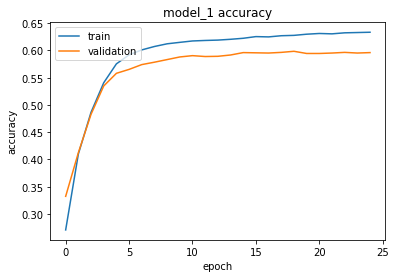

In [61]:
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model_1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The plot of the model accuracy shows that it does not perform better than the benchmark model (less than 0.596 validation accuracy). It moreover reveals significant overfitting, as the training accuracy keeps rising above the validation accuracy from the 4th epoch on.

In [62]:
model_1.save_weights("mc2_model_1.h5")
print("Saved model to disk")

scores_1={}
score_emb_1 = model_1.evaluate(X_test, y_test, verbose=0)
scores_1["GRU_word2vec_reviews"] = score_emb_1
print('Test loss:', score_emb_1[0])
print('Test accuracy:', score_emb_1[1])

Saved model to disk
Test loss: 1.1532263286590576
Test accuracy: 0.596


### Second Model (Bidirectional)
To further improve the results we will implement a bidirectional version of the network. In addition to that, we will define early stopping and callbacks. Moreover we increase the number of neurons in the GRU layer to 16 in order to further improve performace. 

In [63]:
import tensorflow as tf
from keras.applications import Xception
from keras.utils import multi_gpu_model

In [64]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

epochs=25
# Define early stopping with callbacks
es = EarlyStopping(monitor='val_acc', mode='max', min_delta=1, patience=15,
                   restore_best_weights=True,
                   verbose = 1) # Stop training when loss decreases less than 1%
mc = ModelCheckpoint('best_model_2.h5', monitor='val_acc', mode='max', verbose=1)

In [65]:
es

In [66]:
from keras.optimizers import SGD
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

In [75]:
from keras.layers import Bidirectional
embedding_layer_2=Embedding(num_words, #size of vocab
                          emb, #size of embedding 
                          embeddings_initializer=Constant(embedding_matrix), #weights to start with, and not touch during training
                          input_length=major_sen, 
                          trainable=False  # do no update these weights
                         )

model_2 = Sequential()
model_2.add(embedding_layer_2)
model_2.add(Bidirectional(GRU(16), merge_mode="concat"))
model_2.add(Dense(5, activation='softmax'))
model_2.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 550, 100)          51732300  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 32)                11232     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 51,743,697
Trainable params: 11,397
Non-trainable params: 51,732,300
_________________________________________________________________
None


In [76]:
history_2 = model_2.fit(X_train,y_train, batch_size=256, epochs=epochs, validation_data=(X_test,y_test), shuffle=True, verbose=1, 
                        callbacks = [mc])

Train on 7500 samples, validate on 2500 samples
Epoch 1/25
7500/7500 [==============================] - 275s 37ms/step - loss: 0.4340 - acc: 0.8242 - val_loss: 0.3937 - val_acc: 0.8379

Epoch 00001: saving model to best_model_2.h5
Epoch 2/25
7500/7500 [==============================] - 37s 5ms/step - loss: 0.3740 - acc: 0.8486 - val_loss: 0.3826 - val_acc: 0.8415

Epoch 00002: saving model to best_model_2.h5
Epoch 3/25
7500/7500 [==============================] - 32s 4ms/step - loss: 0.3646 - acc: 0.8517 - val_loss: 0.3785 - val_acc: 0.8430

Epoch 00003: saving model to best_model_2.h5
Epoch 4/25
7500/7500 [==============================] - 37s 5ms/step - loss: 0.3595 - acc: 0.8537 - val_loss: 0.3768 - val_acc: 0.8422

Epoch 00004: saving model to best_model_2.h5
Epoch 5/25
7500/7500 [==============================] - 31s 4ms/step - loss: 0.3557 - acc: 0.8549 - val_loss: 0.3762 - val_acc: 0.8426

Epoch 00005: saving model to best_model_2.h5
Epoch 6/25
7500/7500 [=======================

The following graph illustrates training and test accuracy of the bidirectional model. It shows a significant increase in accuracy (test accuracy now at 0.845) compared to the previous GRU model as well as to the benchmark. However it also shows a strong tendency to overfit as the training accuracy is much higher than the test accuracy and keeps rising. However as the validation accuracy does not worsen, overfitting does not appear to have a negative impact on it.

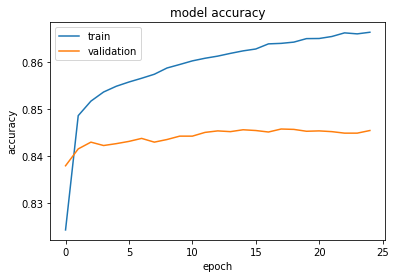

In [77]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The following chart shows the results without Callbacks and "adam" as an optimizer.

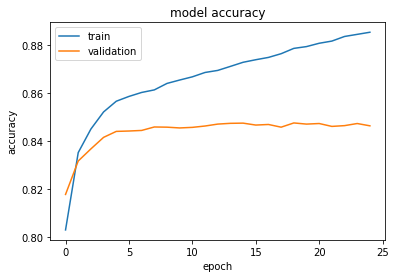

In [317]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [78]:
model_2.save_weights("mc2_model_2.h5")
print("Saved model to disk")

scores_2={}
score_emb_2 = model_2.evaluate(X_test, y_test, verbose=0)
scores_2["GRU_word2vec_reviews"] = score_emb_2
print('Test loss:', score_emb_2[0])
print('Test accuracy:', score_emb_2[1])

Saved model to disk
Test loss: 0.3781320651531219
Test accuracy: 0.8454400001525879


In [79]:
history_2

### Prediction

Based on the best model a prediction for the test data will be made.

In [80]:
np.amax(padded_test)

212253

Words that have not appeared in the training data will need to be substituted by zeros.

In [81]:
padded_test_clean = np.zeros((212849, 550))
for index, value in enumerate(padded_test):
    vector = value
    for i in range(0,550):
              if vector[i] >= num_words:
                  vector[i] = 0
    if vector is not None:
        padded_test_clean[index] = vector
        
print(padded_test_clean.shape)
print(np.amax(padded_test_clean))

(212849, 550)
212253.0


In [82]:
padded_test_clean_int = padded_test_clean.astype(int)

In [83]:
#save the padded test clean data 
with open('padded_test_clean_test_int.pkl','wb') as path_name:
    pickle.dump(padded_test_clean_int, path_name)

In [84]:
pred = model_2.predict(padded_test_clean_int, verbose = 1)

212849/212849 [==============================] - 690s 3ms/step


Save prediction in correct format. 

In [89]:
import csv

In [85]:
pred_rating = np.argmax(pred, axis=1)

In [87]:
sub = pd.DataFrame(data = list(zip(test['product_id'], (pred_rating+1))),
                       columns = ["product_id", "star_rating"])

In [1]:
sub.to_csv('MC02_MaRä.csv', encoding='utf-8', index=False, quoting = csv.QUOTE_NONNUMERIC)

NameError: name 'sub' is not defined

## Evaluation

In the course of this work several different models were built to predict from textual data. The first model was a simple model built on 20k observations. We chose a gated recurrent unit model (GRU) because it addresses the vanishing gradient problem that recurrent neural networks (RNN) suffer from. As long short-term memory (LSTM) model would have been possible as well. As scientific research does not prove that one of the two models is profoundly more suitable for the task at hand we chose the GRU model (1). 
When comparing the validation accuracy of the GRU model to the benchmark logit model it appears that it performs comparably low.
In order to improve performance we incorporated a bidirectional architecture into our GRU model. We chose a bidirectional architecture because it enables the model to learn not only from past data as conventional recurrent neural networks do, but also consider future context (2). As we are working on a natural language processing task this makes sense because the meaning of a word does not only depend on the words that came before it in a sentence but also on the ones that come after.
As shown in the above plots the bidirectional model improved performance significantly. 


## Discussion

The validation accuracy of the bidirectional GRU model is comparably high. However, when looking at the resulting predictions it seems that the model has a bias towards predicting the majority class of five star ratings. This can be explained by the fact, that the training and test data is highly unbalanced. To tackle this problem a model built on a balanced subsample was built in a separate notebook. However it resulted in an extremely low validation accuracy of around 40% after 25 epochs and was therefore not further pursued.

## Outlook

Further improvements in validation accuracy and better generalization abilities might have been accomplished by including drop out, building a model with more layers or with different numbers of neurons. We would gladly have experimented with these parameters however as training a word2vector model on 1m observations was very time consuming and we originally tried to train our model on the full data set we were forced to focus on building a working model in the time that was left.
It should be mentioned that this predictions task could have been tackled in a slightly different way. We used the combination of review titles and review bodies to predict ratings. However most people already summarise their opinion in the review title. It might have have been sufficient to train the model on review titles and ignore the time consuming training on the review texts.

## Bibliography

(1)  J. Chung, C. Gulcehre, K. Cho, and Y. Bengio, “Empirical evaluation of gated recurrent neural networks on sequence modeling,” arXiv preprint arXiv:1412.3555, 2014.

(2) H. Salehinejad, S. Sankar, J. Barfett, E.Colak, and S. Valaee, “Recent Advances in Recurrent Neural Networks”, arXiv: 1801.01078v3, 2018
